In [1]:
#Importing some necessary packages

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

### Define functions

In [2]:
# A function that allows us to drop rows based on values we think are suspect

def drop_rows(df, colname, val):
    return df[df[colname] != val]

In [3]:
# A function to take columns with years (yr_built, yr_renovated) and bin them by decade

from sklearn.preprocessing import LabelEncoder

def bin_by_decade(df, colname):
    bins = pd.IntervalIndex.from_tuples([(1900, 1909), (1910, 1919), (1920, 1929), (1930, 1939), (1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2010), (2010, 2020)])
    series = pd.cut(df[colname], bins)
    df[colname] = series
    return df

In [4]:
# Contains all of our data cleaning operations

def clean():
    
# Load the data
    
    house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')
    
# Get rid of rows
    # The row with 33 bedrooms is a suspicious outlier, so we decided to drop it
    # The 454 ?s in sqft_basement needed to be remedied. We chose to drop them--454 seemed like too many to impute. 

    clean_house = house[house['bedrooms'] != 33]
    clean_house = clean_house[clean_house['sqft_basement'] != "?"]
    
# Bin decades
    
    clean_house = bin_by_decade(clean_house, 'yr_built')
    clean_house = bin_by_decade(clean_house, 'yr_renovated')
    
    
# Get dummies
    # Note: Originally, we dropped waterfront because it had a lot of null values. Get dummies gives you the option to create a dummy for nulls or not.
    # We did that, without the null column
    clean_house = pd.get_dummies(clean_house, columns=(['waterfront', 'view', 'floors', 'bedrooms', 'bathrooms','condition', 'grade','zipcode', 'yr_built', 'yr_renovated']))
    
# Drop id, date, waterfront

    clean_house = clean_house.drop(['id', 'date'], axis=1)
    
# Convert sqft_basement from object to float

    clean_house['sqft_basement'] = clean_house['sqft_basement'].astype(float, inplace=True)

# Return clean_house
    
    return clean_house

### Get clean dataframe

In [5]:
clean_house = clean()


In [6]:
clean_house.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront_0.0,...,"yr_renovated_(1920, 1929]","yr_renovated_(1930, 1939]","yr_renovated_(1940, 1949]","yr_renovated_(1950, 1959]","yr_renovated_(1960, 1969]","yr_renovated_(1970, 1979]","yr_renovated_(1980, 1989]","yr_renovated_(1990, 1999]","yr_renovated_(2000, 2010]","yr_renovated_(2010, 2020]"
0,221900.0,1180,5650,1180,0.0,47.5112,-122.257,1340,5650,0,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2570,7242,2170,400.0,47.7210,-122.319,1690,7639,1,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,770,10000,770,0.0,47.7379,-122.233,2720,8062,1,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,1050,910.0,47.5208,-122.393,1360,5000,1,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,1680,8080,1680,0.0,47.6168,-122.045,1800,7503,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
clean_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21142 entries, 0 to 21596
Columns: 172 entries, price to yr_renovated_(2010, 2020]
dtypes: float64(4), int64(5), uint8(163)
memory usage: 4.9 MB


### Split the data into training and test sets

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
Split data into train and test sets

X = clean_house.drop(["price"], axis=1) #predictors
y = clean_house["price"] #target

SyntaxError: invalid syntax (<ipython-input-9-99c9129073f1>, line 1)

In [10]:
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)
# print(len(X_test), len(X_train), len(y_test), len(y_train))

### Regression 1: Manual scaling and feature selection

In [11]:
# copied function from Model Fit Linear Regression Lab

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [12]:
X = clean_house["price"]
y = clean_house.drop(["price"], axis=1)

result = stepwise_selection(predictors, target, verbose = True)
print('resulting features:')
print(result)

NameError: name 'predictors' is not defined

In [13]:
import statsmodels.api as sm
from sklearn import preprocessing

# Used Scikitlearn's Standard Scaler
    # Takes each data point, subtracts the mean of the sample, then divides by the standard deviation of the sample

ss_scaler = preprocessing.StandardScaler()
clean_house_ss = ss_scaler.fit_transform(clean_house)

# Standard scaler returns a numpy array, so we converted it back to a DF

clean_house_ss = pd.DataFrame(clean_house_ss, columns=list(clean_house.columns))

# We generated a list of features to use using a stepwise selection function from Flatiron's learn.co lessons
    # Finds the best p values from your features
    # Note: The resulting list contains 79 of the original 135 features

clean_house_selections_list = ['price','sqft_living15', 'view_0.0', 'sqft_basement', 'zipcode_98004', 'sqft_above', 'sqft_living', 'lat', 'waterfront_1.0', 'zipcode_98039', 'zipcode_98112', 'zipcode_98040', 'grade_13', 'grade_12', 'grade_11', 'grade_10', 'grade_9', 'zipcode_98105', 'zipcode_98119', 'condition_5', 'zipcode_98109', 'zipcode_98199', 'view_4.0', 'zipcode_98033', 'zipcode_98103', 'zipcode_98102', 'zipcode_98122', 'zipcode_98115', 'zipcode_98117', 'zipcode_98116', 'zipcode_98107', 'zipcode_98006', 'zipcode_98144', 'zipcode_98005', 'zipcode_98136', 'zipcode_98008', 'yr_renovated_(2000, 2010]', 'bathrooms_7.75', 'zipcode_98029', 'zipcode_98052', 'condition_4', 'bathrooms_8.0', 'zipcode_98126', 'view_3.0', 'zipcode_98027', 'bathrooms_6.0', 'zipcode_98007', 'zipcode_98118', 'bathrooms_4.75', 'yr_built_(2010, 2020]', 'zipcode_98053', 'zipcode_98074', 'sqft_lot', 'zipcode_98075', 'zipcode_98034', 'zipcode_98125', 'zipcode_98177', 'floors_3.0', 'grade_8', 'floors_2.0', 'bathrooms_4.25', 'bedrooms_3', 'bathrooms_3.25', 'zipcode_98106', 'yr_renovated_(2010, 2020]', 'bathrooms_3.75', 'bathrooms_4.5', 'bedrooms_7', 'bathrooms_4.0', 'bathrooms_5.5', 'bathrooms_5.25', 'yr_built_(1930, 1939]', 'bathrooms_5.0', 'bathrooms_6.25', 'yr_renovated_(1990, 1999]', 'zipcode_98023', 'zipcode_98178', 'zipcode_98198', 'bedrooms_6', 'floors_2.5', 'bedrooms_10', 'yr_built_(1920, 1929]', 'zipcode_98024', 'zipcode_98146', 'zipcode_98133', 'zipcode_98108', 'zipcode_98045', 'zipcode_98010', 'bathrooms_5.75', 'bedrooms_9', 'bedrooms_5', 'sqft_lot15', 'condition_1', 'bathrooms_2.25', 'bathrooms_1.0', 'zipcode_98059', 'zipcode_98056', 'zipcode_98072', 'zipcode_98038', 'zipcode_98065', 'zipcode_98022', 'long', 'bathrooms_3.0']
print("The number of features used in the model is:", len(clean_house_selections_list))

# Made a new DF with just the features from our selections list
clean_house_selections = clean_house_ss[clean_house_selections_list]

# # Used statsmodels OLS so we could get a handy summary of the regression results
target = clean_house_selections["price"]
predictors = clean_house_selections.drop(["price"], axis=1)

predictors_int = sm.add_constant(predictors)
model = sm.OLS(target, predictors_int).fit()
model.summary()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


The number of features used in the model is: 103


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     1122.
Date:                Sat, 11 May 2019   Prob (F-statistic):               0.00
Time:                        15:00:56   Log-Likelihood:                -10402.
No. Observations:               21142   AIC:                         2.101e+04
Df Residuals:                   21040   BIC:                         2.182e+04
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -3.175e-15      0.003  -1.16e-12      1.000      -0.005       0.005
sqft_living15                 0.0449      0.005      9.035      0.000       0.035       0.055
view_0.0                     -0.0629      0.004    -17.446      0.000      -0.070      -0.056
sqft_basement                 0.0477      0.003     15.447      0.000       0.042       0.054
zipcode_98004                 0.2214      0.003     76.229      0.000       0.216       0.227
sqft_above                    0.1811      0.003     51.982      0.000       0.174       0.188
sqft_living                   0.1863      0.003     60.650      0.000       0.180       0.192
lat                           0.1228      0.005     27.193      0.000       0.114       0.132
waterfront_1.0                0.1337      0.003     39.851      0.000       0.127       0.140
zipcode_98039                 0.1397      0.003     49.479      0.000       0.134       0.145
zipcode_98112                 0.1583      0.003     53.693      0.000       0.152       0.164
zipcode_98040                 0.1323      0.003     45.615      0.000       0.127       0.138
grade_13                      0.1032      0.003     32.601      0.000       0.097       0.109
grade_12                      0.1329      0.003     41.544      0.000       0.127       0.139
grade_11                      0.1447      0.004     40.198      0.000       0.138       0.152
grade_10                      0.1310      0.004     33.652      0.000       0.123       0.139
grade_9                       0.0877      0.004     22.058      0.000       0.080       0.095
zipcode_98105                 0.1037      0.003     35.388      0.000       0.098       0.109
zipcode_98119                 0.0970      0.003     33.094      0.000       0.091       0.103
condition_5                   0.0567      0.003     19.393      0.000       0.051       0.062
zipcode_98109                 0.0764      0.003     26.911      0.000       0.071       0.082
zipcode_98199                 0.0900      0.003     28.715      0.000       0.084       0.096
view_4.0                      0.0710      0.004     19.736      0.000       0.064       0.078
zipcode_98033                 0.0956      0.003     32.194      0.000       0.090       0.101
zipcode_98103                 0.1029      0.003     30.416      0.000       0.096       0.110
zipcode_98102                 0.0723      0.003     25.392      0.000       0.067       0.078
zipcode_98122                 0.0804      0.003     27.543      0.000       0.075       0.086
zipcode_98115                 0.0967      0.003     30.299      0.000       0.090       0.103
zipcode_98117                 0.0845      0.003     25.034      0.000       0.078       0.091
zipcode_98116                 0.0677      0.003     22.150      0.000      

### Model Validation

In [14]:
# We needed a train, test, split for our standardized data set
# y = clean_house_selections["price"]
# X = clean_house_selections.drop(["price"], axis=1)

y = clean_house["price"]
X = clean_house_ss.drop(["price"], axis=1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# predictors_int = sm.add_constant(X1_train)
# model = sm.OLS(y1_train, predictors_int).fit()
# model.summary()

# model.predict(X1_train)


In [15]:
from sklearn.metrics import r2_score

print(r2_score(y_train, y_hat_train))
print(r2_score(y_test, y_hat_test))

0.8452259842441969
-6.344303860281297e+17


In [16]:
linreg.coef_

array([ 1.44999521e+16,  1.03120000e+04, -1.30768855e+16, -6.98513483e+15,
        4.55080000e+04, -3.26100000e+04,  1.71730000e+04, -4.33875000e+03,
        8.52000000e+02,  5.14070000e+04, -1.29043750e+04,  6.23046094e+03,
        6.91920312e+03,  1.81874375e+04,  2.77822500e+04,  4.41400717e+16,
        2.50381509e+16,  4.28854208e+16,  7.55562238e+15,  1.45769211e+16,
        1.60617646e+15, -6.38024445e+15, -2.24742423e+16, -3.35845711e+16,
       -3.14238655e+16, -1.76282450e+16, -7.45991964e+15, -2.78017717e+15,
       -1.67158861e+15, -1.13580894e+15, -8.03195197e+14, -4.63746900e+14,
       -2.52688341e+15, -1.22730953e+16, -8.10942950e+16, -4.37606928e+15,
       -5.31356027e+16, -7.39231037e+16, -6.04694809e+16, -6.22797516e+16,
       -9.16831794e+16, -4.83093094e+16, -3.88866208e+16, -3.44773863e+16,
       -3.84509055e+16, -1.79229862e+16, -1.68978426e+16, -1.29436278e+16,
       -1.42627332e+16, -6.99331274e+15, -6.35677672e+15, -5.25888296e+15,
       -4.37606928e+15, -

In [17]:
 # convert standardized coefficients to unstandardized

# for ind, val in enumerate(model.params):
#     print(predictors.loc[ind], val * (target.std()/predictors.loc[ind].std()))

# for ind, val in enumerate(linreg.coef_):
#     print((val + X.iloc[:,ind].mean()) / X.iloc[:,ind].std())

# ss_scaler.inverse_transform(y_hat_train)


X1 = clean_house.drop(["price"], axis=1)

for ind, val in enumerate(linreg.coef_):
    print(list(X.columns)[ind], val * X1.iloc[:,ind].std() + X1.iloc[:,ind].mean())
    
# for ind, val in enumerate(linreg.coef_):
#     print(list(X.columns)[ind], val + X1.iloc[:,ind].mean() / X1.iloc[:,ind].std())

sqft_living 1.3319131379124433e+19
sqft_lot 424973920.2964623
sqft_above -1.0833066375286962e+19
sqft_basement -3.090952644498557e+18
lat 6354.601750601425
long -4707.114978925581
sqft_living15 11777026.627020985
sqft_lot15 -117870490.62823373
waterfront_0.0 275.09350127252577
waterfront_1.0 4198.952647356886
view_0.0 -3879.278504153641
view_1.0 768.8740449058291
view_2.0 1418.9917325585411
view_3.0 2752.9493260164977
view_4.0 3344.7894262275317
floors_1.0 2.206922894156004e+16
floors_1.5 7101099482853825.0
floors_2.0 2.0832454550318276e+16
floors_2.5 646638532676656.0
floors_3.0 2406870361167755.5
floors_3.5 29221843169217.51
bedrooms_1 -603699175644061.4
bedrooms_2 -7490590670445782.0
bedrooms_3 -1.672728893981951e+16
bedrooms_4 -1.464418348777318e+16
bedrooms_5 -4608547873646322.0
bedrooms_6 -825304559382836.1
bedrooms_7 -114628047054265.5
bedrooms_8 -41438569443983.42
bedrooms_9 -19131829831451.027
bedrooms_10 -9567272681875.346
bedrooms_11 -3189392619754.135
bathrooms_0.5 -3009901

In [18]:
# Check the mean squared error

from math import sqrt

mse_train = sqrt(np.sum((y_train-y_hat_train)**2)/len(y_train))
mse_test = sqrt(np.sum((y_test-y_hat_test)**2)/len(y_test))
print('Train Root Mean Squared Error:', mse_train)
print('Test Root Mean Squared Error:', mse_test)

Train Root Mean Squared Error: 146968.1527791003
Test Root Mean Squared Error: 274950636677540.72


In [19]:
# Mean absolute error

print(mean_absolute_error(y_train, y_hat_train))
print(mean_absolute_error(y_test, y_hat_test))

NameError: name 'mean_absolute_error' is not defined

In [20]:
# Cross validation scores
    # Took the mean cv score because cross_val_score returns a score for each fold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

cv_5_results = np.mean(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error"))

In [21]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-4.09772150491108e+35
-4.463915050521243e+34
-3.4230218909774445e+35


In [22]:
clean_house_ss.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront_0.0,...,"yr_renovated_(1920, 1929]","yr_renovated_(1930, 1939]","yr_renovated_(1940, 1949]","yr_renovated_(1950, 1959]","yr_renovated_(1960, 1969]","yr_renovated_(1970, 1979]","yr_renovated_(1980, 1989]","yr_renovated_(1990, 1999]","yr_renovated_(2000, 2010]","yr_renovated_(2010, 2020]"
0,-0.865602,-0.980840,-0.229016,-0.735284,-0.659530,-0.354058,-0.306763,-0.944064,-0.260932,-2.742547,...,0.0,-0.006878,-0.013756,-0.026646,-0.03509,-0.039539,-0.073304,-0.074276,-0.100162,-0.078961
1,-0.006808,0.532428,-0.190384,0.459800,0.244437,1.159775,-0.747747,-0.433603,-0.187724,0.364625,...,0.0,-0.006878,-0.013756,-0.026646,-0.03509,-0.039539,-0.073304,13.463232,-0.100162,-0.078961
2,-0.979438,-1.427199,-0.123457,-1.230217,-0.659530,1.281718,-0.136059,1.068609,-0.172155,0.364625,...,0.0,-0.006878,-0.013756,-0.026646,-0.03509,-0.039539,-0.073304,-0.074276,-0.100162,-0.078961
3,0.172503,-0.131668,-0.244789,-0.892214,1.396995,-0.284788,-1.274082,-0.914895,-0.284856,0.364625,...,0.0,-0.006878,-0.013756,-0.026646,-0.03509,-0.039539,-0.073304,-0.074276,-0.100162,-0.078961
4,-0.082880,-0.436499,-0.170049,-0.131706,-0.659530,0.407909,1.201118,-0.273173,-0.192730,0.364625,...,0.0,-0.006878,-0.013756,-0.026646,-0.03509,-0.039539,-0.073304,-0.074276,-0.100162,-0.078961


### Regression 2: Lasso

In [23]:
from sklearn.linear_model import Lasso

In [24]:
# Lasso Regression
    # Lasso helps prevent overfitting by reducing the influence of some of the predictors by penalizing their coefficients or reducing them to zero (effectively doing predictor selection)
y = clean_house["price"]
X = clean_house_ss.drop(["price"], axis=1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)

lasso = Lasso(alpha=20)
lasso.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [25]:
# Checking the training/test scores (R2) of our model 

train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)

In [26]:
print("training score:", train_score)
print("test score: ", test_score)

training score: 0.8452252423626986
test score:  0.8334261550862682


In [27]:
# Checking to see how many features were used and how many were axed

coeff_used = np.sum(lasso.coef_!=0)
print("number of features used:", coeff_used)
print("number eliminated:", len(list(clean_house.columns)) - coeff_used)

number of features used: 163
number eliminated: 9


In [28]:
# Mean Squared Error

from sklearn.metrics import mean_squared_error

y_hat_train = lasso.predict(X_train)
y_hat_test = lasso.predict(X_test)

mse_train = sqrt(mean_squared_error(y_train, y_hat_train))
mse_test = sqrt(mean_squared_error(y_test, y_hat_test))
print('Train Root Mean Squared Error:', mse_train)
print('Test Root Mean Squared Error:', mse_test)

Train Root Mean Squared Error: 146968.50501142495
Test Root Mean Squared Error: 140885.45120347332


In [29]:
# Mean absolute error

mae = mean_absolute_error(y_hat_test, y_test)
mae

85814.93868750872

In [30]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(lasso, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(lasso, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(lasso, X, y, cv=20, scoring="neg_mean_squared_error"))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

KeyboardInterrupt: 

In [ ]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

In [ ]:

# for ind, val in enumerate(lasso.coef_):
#     print(list(X.columns)[ind], val) 

In [31]:
lasso_coef = pd.DataFrame(np.round_(lasso.coef_, decimals=3), X.columns, columns=["penalized_coefficients"])

In [32]:
lasso_coef

,penalized_coefficients
sqft_living,122475.566
sqft_lot,10187.857
sqft_above,16799.965
sqft_basement,-10859.170
lat,47317.914
long,-31170.728
sqft_living15,17180.545
sqft_lot15,-4259.004
waterfront_0.0,872.745
waterfront_1.0,51355.634


[Text(0, 0, 'View Rating 0'),
 Text(0, 0, 'Condition 3'),
 Text(0, 0, 'Zipcode 98198'),
 Text(0, 0, 'Zipcode 98155'),
 Text(0, 0, 'Building Grade 8'),
 Text(0, 0, 'Zipcode 98023'),
 Text(0, 0, 'Building Grade 6'),
 Text(0, 0, 'Longitude'),
 Text(0, 0, 'Building Grade 7')]

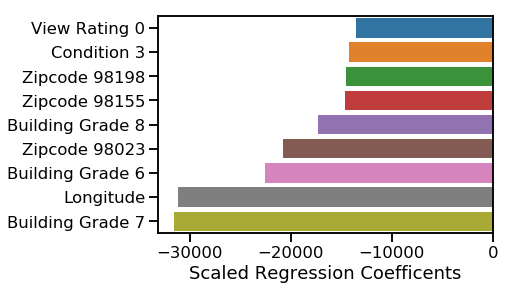

In [42]:
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_context('talk')
fig = plt.figure()
plt.tight_layout()

lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
lasso_coef = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)

ax = sns.barplot(x="penalized_coefficients", y=lasso_coef.index, data=lasso_coef)
ax.set(xlabel='Scaled Regression Coefficents')
ax.set_yticklabels(["View Rating 0", "Condition 3", "Zipcode 98198","Zipcode 98155","Building Grade 8", "Zipcode 98023", "Building Grade 6", "Longitude", "Building Grade 7"])
# fig.savefig("top coefficients", bbox_inches='tight')

[Text(0.5, 0, 'Scaled Regression Coefficents')]

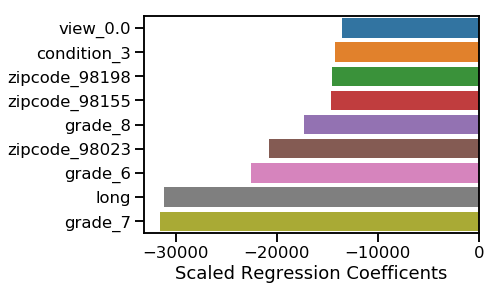

In [43]:
lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
lasso_coef = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)
ax = sns.barplot(x="penalized_coefficients", y=lasso_coef.index, data=lasso_coef)
ax.set(xlabel='Scaled Regression Coefficents')
# ax.set_yticklabels(["Square Feet Living", "Zipcode 98004", "Waterfront","Zipcode 98112","Latitude", "Zipcode 98039", "Building Grade 11", "Building Grade 12", "Zipcode 98040", "Grade 13"])
# fig.savefig("positive coefficients", bbox_inches='tight')

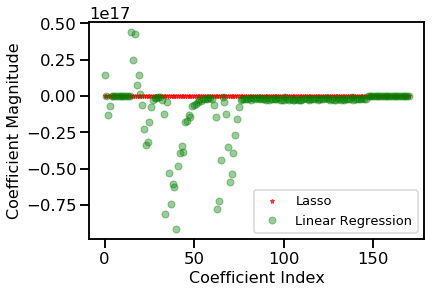

In [35]:
plt.plot(lasso.coef_, alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label='Lasso') # zorder for ordering the markers

plt.plot(linreg.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

KeyboardInterrupt: 

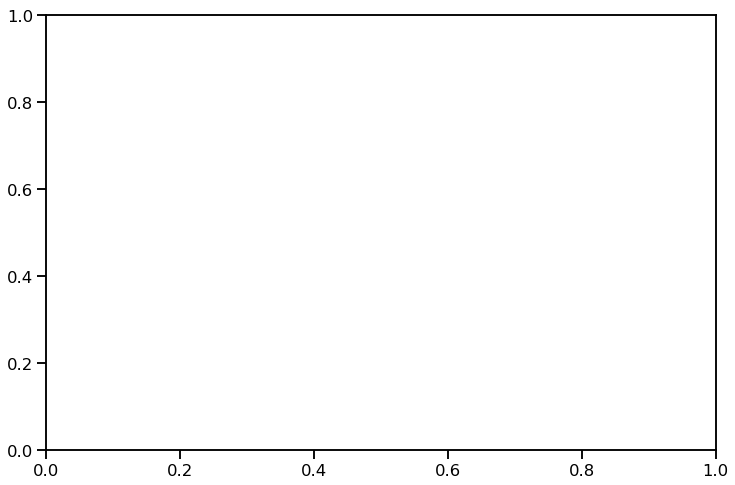

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "price", fig=fig)

In [ ]:

sns.residplot(y_hat_train, y_hat_test)

### Regression 3: Ridge

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
# An important difference between Lasso and Ridge is that Ridge doesn't reduce any features' coefficient to 0 (though they can get very, very small)

ridge = Ridge()
ridge.fit(X_train, y_train)

In [ ]:
# Getting the scores

rtrain_score=ridge.score(X_train,y_train)
rtest_score=ridge.score(X_test,y_test)

In [ ]:
print("training score:", rtrain_score)
print("test score: ", rtest_score)

In [ ]:
# Mean Squared Error

y_hat_train = ridge.predict(X_train)
y_hat_test = ridge.predict(X_test)

mse_train = sqrt(np.sum((y_train-y_hat_train)**2)/len(y_train))
mse_test = sqrt(np.sum((y_test-y_hat_test)**2)/len(y_test))
print('Train Root Mean Squarred Error:', mse_train)
print('Test Root Mean Squarred Error:', mse_test)

In [ ]:
# Mean absolute error

mae = mean_absolute_error(y_hat_test, y_test)
mae

In [ ]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(ridge, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(ridge, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(ridge, X, y, cv=20, scoring="neg_mean_squared_error"))

In [ ]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

In [ ]:
# for ind, val in enumerate(ridge.coef_):
#     print(list(X.columns)[ind], val)

### Try Gridsearch for best alpha

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param = {'alpha': [1, 5, 10, 20, 25, 30, 35]}

In [ ]:
lasso_regressor = GridSearchCV(lasso, param, scoring='neg_mean_squared_error', cv=10)
lasso_regressor.fit(X, y)

print('Best parameters:', lasso_regressor.best_params_)
print('Best score:', lasso_regressor.best_score_)

In [ ]:
lasso = Lasso(alpha = 20)
lasso.fit(X_train, y_train)

In [ ]:
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)

In [ ]:
print("training score:", train_score)
print("test score: ", test_score)

In [ ]:
coeff_used = np.sum(lasso.coef_!=0)
print("number of features used:", coeff_used)
print("number eliminated:", len(list(clean_house.columns)) - coeff_used)

In [ ]:
# Mean Squared Error
y_hat_train = lasso.predict(X_train)
y_hat_test = lasso.predict(X_test)

mse_train = sqrt(np.sum((y_train-y_hat_train)**2)/len(y_train))
mse_test = sqrt(np.sum((y_test-y_hat_test)**2)/len(y_test))
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)

In [ ]:
# Mean absolute error

mse = mean_absolute_error(y_hat_test, y1_test)
mse

In [ ]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(lasso, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(lasso, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(lasso, X, y, cv=20, scoring="neg_mean_squared_error"))

In [ ]:
print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

In [ ]:
for ind, val in enumerate(lasso.coef_):
    print(list(X.columns)[ind], val)

Text(0.5, 0, '')

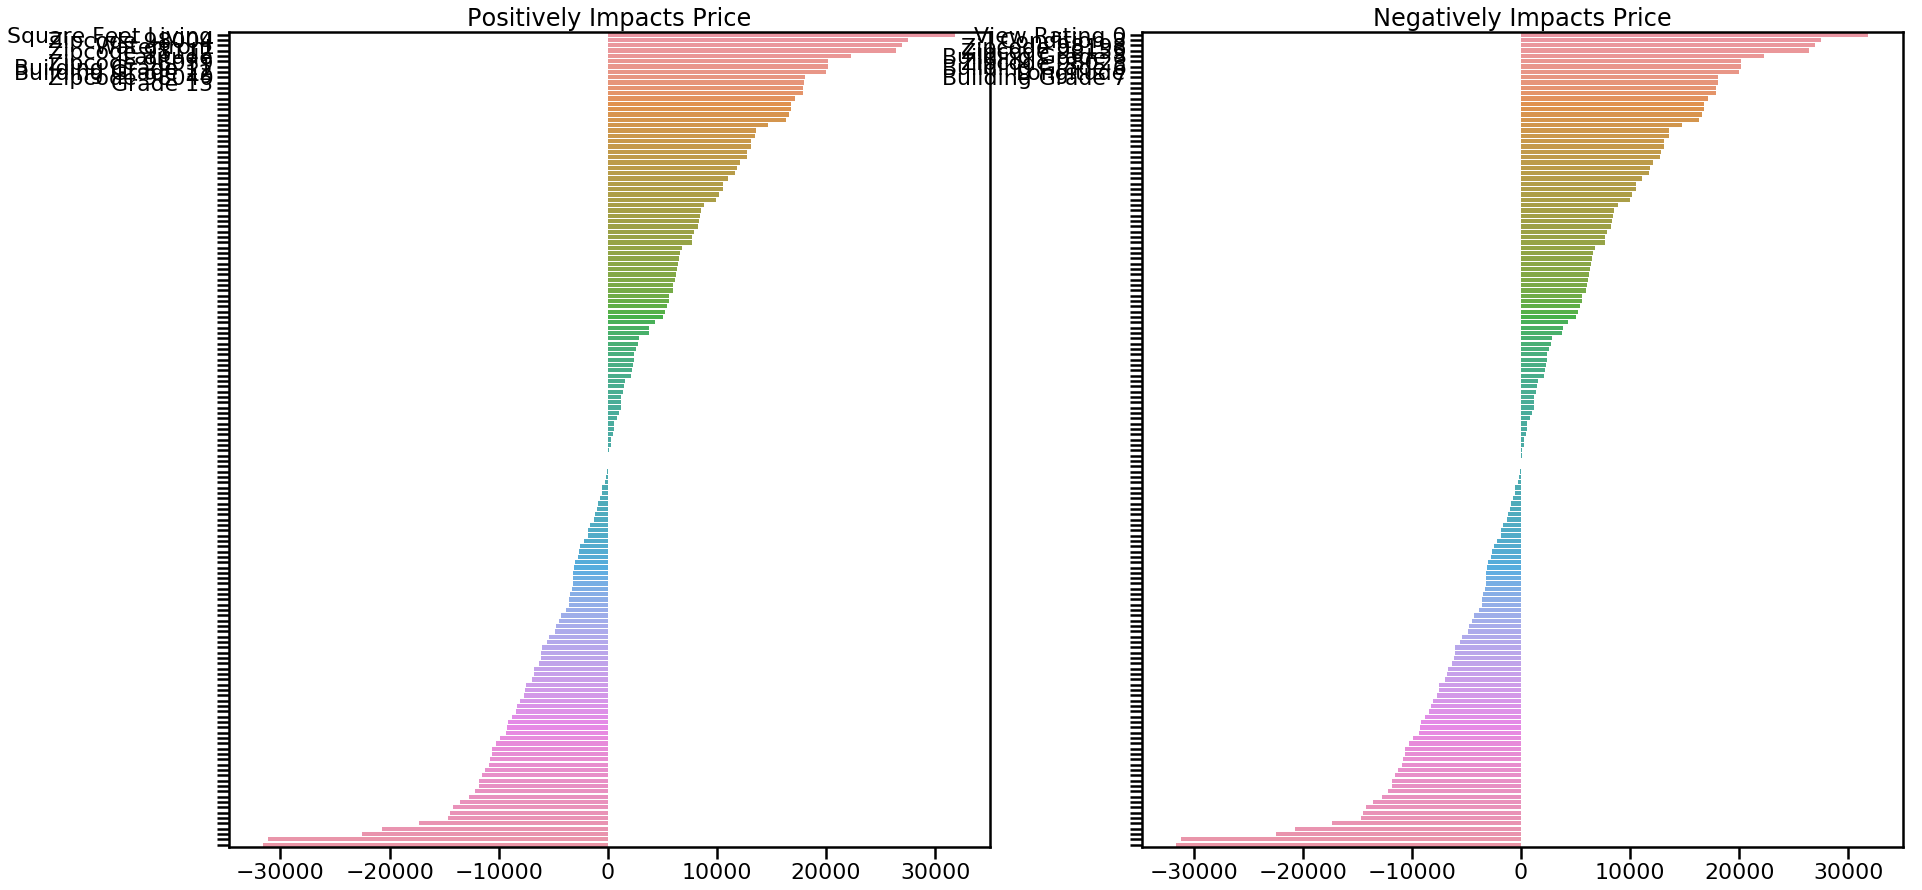

In [47]:
fig = plt.figure(figsize=(30,15))
sns.set_context('poster')

lasso_coef = pd.DataFrame(np.round_(lasso.coef_, decimals=3), X.columns, columns=["penalized_coefficients"])
lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
lasso_coef = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)[10:]


plt.subplot(1,2,1)
ax = sns.barplot(x="penalized_coefficients", y=lasso_coef.index, data=lasso_coef)
ax.set(title='Positively Impacts Price')
ax.set_yticklabels(["Square Feet Living", "Zipcode 98004", "Waterfront","Zipcode 98112","Latitude", "Zipcode 98039", "Building Grade 11", "Building Grade 12", "Zipcode 98040", "Grade 13"])
ax.set_xlabel('')

lasso_coef2 = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)[-10:]

plt.subplot(1,2,2)
ax = sns.barplot(x="penalized_coefficients", y=lasso_coef.index, data=lasso_coef)
ax.set(title='Negatively Impacts Price')
ax.set_yticklabels(["View Rating 0", "Condition 3", "Zipcode 98198","Zipcode 98155","Building Grade 8", "Zipcode 98023", "Building Grade 6", "Longitude", "Building Grade 7"])
ax.set_xlabel('')
# fig.savefig("coefficients", bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(30,15))
sns.set_context('talk')

lasso_coef = pd.DataFrame(np.round_(lasso.coef_, decimals=3), X.columns, columns=["penalized_coefficients"])
lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
lasso_coef1 = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)[:10]


plt.subplot(1,2,1)
ax = sns.barplot(x="penalized_coefficients", y=lasso_coef1.index, data=lasso_coef1)
ax.set(title='Positively Impacts Price')
ax.set_yticklabels(["Square Feet Living", "Zipcode 98004", "Waterfront","Zipcode 98112","Latitude", "Zipcode 98039", "Building Grade 11", "Building Grade 12", "Zipcode 98040", "Grade 13"])
ax.set_xlabel('')


lasso_coef2 = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)[-10:]


plt.subplot(1,2,2)
ax = sns.barplot(x="penalized_coefficients", y=lasso_coef2.index, data=lasso_coef2)
ax.set(title='Negatively Impacts Price', )
ax.set_yticklabels(["Zipcode 98178", "View Rating 0", "Condition 3", "Zipcode 98198","Zipcode 98155","Building Grade 8", "Zipcode 98023", "Building Grade 6", "Longitude", "Building Grade 7"])
ax.set_xlabel('')
fig.savefig("coefficients", bbox_inches='tight')